In [1]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
import dask.delayed as delayed
import time
import math
import itertools
from netCDF4 import Dataset
import os,datetime,sys,fnmatch
import matplotlib.pyplot as plt
import dask
from dask.distributed import as_completed
from dask.distributed import Client, LocalCluster

def read_filelist(loc_dir,prefix,unie,fileformat):
    # Read the filelist in the specific directory
    str = os.popen("ls "+ loc_dir + prefix + unie + "*."+fileformat).read()
    fname = np.array(str.split("\n"))
    fname = np.delete(fname,len(fname)-1)
    return fname

def read_MODIS(fname1,fname2,verbose=False): # READ THE HDF FILE
    # Read the cloud mask from MYD06_L2 product') 
    ncfile=Dataset(fname1,'r')
    CM1km = np.array(ncfile.variables['Cloud_Mask_1km'])
    CM   = (np.array(CM1km[:,:,0],dtype='byte') & 0b00000110) >>1
    ncfile.close()
    
    ncfile=Dataset(fname2,'r')
    lat  = np.array(ncfile.variables['Latitude'])
    lon  = np.array(ncfile.variables['Longitude'])
    attr_lat = ncfile.variables['Latitude']._FillValue
    attr_lon = ncfile.variables['Longitude']._FillValue
    return lat,lon,CM

def countzero(x, axis=1):
    #print(x)
    count0 = 0
    count1 = 0
    for i in x:
        if i <= 1:
            count0 +=1
    #print(count0/len(x))
    return (count0/len(x))

MYD06_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD06_prefix = 'MYD06_L2.A2008'
MYD03_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD03_prefix = 'MYD03.A2008'
fileformat = 'hdf'

fname1,fname2 = [],[]


days = np.arange(1,31,dtype=np.int)
for day in days:
    dc ='%03i' % day
    fname_tmp1 = read_filelist(MYD06_dir,MYD06_prefix,dc,fileformat)
    fname_tmp2 = read_filelist(MYD03_dir,MYD03_prefix,dc,fileformat)
    fname1 = np.append(fname1,fname_tmp1)
    fname2 = np.append(fname2,fname_tmp2)

# Initiate the number of day and total cloud fraction
files  = np.arange(len(fname1))



for j in range(0,1):#hdfs:
    print('steps: ',j+1,'/ ',(fname1)) 

    # Read Level-2 MODIS data
    lat,lon,CM = read_MODIS(fname1[j],fname2[j])

combs=[]
for x in range(0,180):
    for y in range(0,360):
        combs.append((x, y))
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']

b1=[]
def aggregateOneFileData(M06_file, M03_file):
    
    cm = np.zeros((2030,1354), dtype=np.float32)
    lat = np.zeros((2030,1354), dtype=np.float32)
    lon = np.zeros((2030,1354), dtype=np.float32)
    
    myd06 = Dataset(M06_file, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    
    
    cm = da.concatenate((cm,CM),axis=0)
    
    cm=da.ravel(cm)
    
    myd03 = Dataset(M03_file, "r")
    latitude = myd03.variables["Latitude"][:,:]
    longitude = myd03.variables["Longitude"][:,:]
    
    lat = da.concatenate((lat,latitude),axis=0)
    lon = da.concatenate((lon,longitude),axis=0)
    #print("lat shape after con:",lat.shape)
    #print("lon shape after con:",lon.shape)
    
    lat=da.ravel(lat)
    lon=da.ravel(lon)
    
    #print("lat shape after ravel:",lat.shape)
    #print("lon shape after ravel:",lon.shape)
    cm=cm.astype(int)
    lon=lon.astype(int)
    lat=lat.astype(int)
    lat=lat+90
    lon=lon+180
    Lat=lat.to_dask_dataframe()
    Lon=lon.to_dask_dataframe()
    CM=cm.to_dask_dataframe()
    df=dd.concat([Lat,Lon,CM],axis=1,interleave_partitions=False)
    print(type(df))
    
    cols = {0:'Latitude',1:'Longitude',2:'CM'}
    df = df.rename(columns=cols)
    
    df2=(df.groupby(['Longitude','Latitude']).CM.apply(countzero).reset_index())
    df3=df2.compute()
    b1.append(df2)
    return b1

cluster = LocalCluster()
client = Client(cluster)

tt=client.map(aggregateOneFileData,fname1,fname2)

res=client.gather(tt)

merged=list(itertools.chain(*res))

b2=dd.concat(merged)
b_2=b2.groupby(['Latitude','Longitude']).mean().reset_index().compute()
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']
df4=pd.merge(df_1, b_2,on=('Latitude','Longitude'), how='left')
df_cm=df4['CM'].values
np_cm=df_cm.reshape(180,360)

client.close()



steps:  1 /  ['/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf']


/Users/dprakas1/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


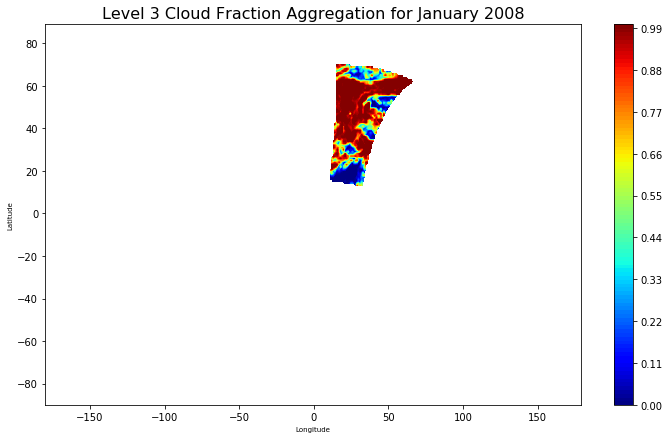

In [3]:
plt.figure(figsize=(12,7))
plt.contourf(range(-180,180), range(-90,90), np_cm, 100, cmap = "jet")
plt.xlabel("Longitude", fontsize = 7)
plt.ylabel("Latitude", fontsize = 7)
plt.title("Level 3 Cloud Fraction Aggregation for January 2008", fontsize = 16)
plt.colorbar()
#plt.savefig("monthlyCloudFraction-file-level-parallelization.png")
plt.show()

